In [4]:
rdd = sc.textFile('../2015_07_22_mktplace_shop_web_log_sample.log')
rdd = rdd.map(lambda line: line.split(" "))

from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

rdd = rdd.map(lambda line: Row(timestamp=line[0], ipaddress=line[2].split(':')[0],url=line[12]))


In [5]:
mainDF = rdd.toDF()

In [6]:
mainDF.show(50)

+---------------+--------------------+--------------------+
|      ipaddress|           timestamp|                 url|
+---------------+--------------------+--------------------+
|123.242.248.130|2015-07-22T09:00:...|https://paytm.com...|
|  203.91.211.44|2015-07-22T09:00:...|https://paytm.com...|
|    1.39.32.179|2015-07-22T09:00:...|https://paytm.com...|
| 180.179.213.94|2015-07-22T09:00:...|https://paytm.com...|
| 120.59.192.208|2015-07-22T09:00:...|https://paytm.com...|
| 117.239.195.66|2015-07-22T09:00:...|https://paytm.com...|
|  101.60.186.26|2015-07-22T09:00:...|https://paytm.com...|
|   59.183.41.47|2015-07-22T09:00:...|https://paytm.com...|
| 117.239.195.66|2015-07-22T09:00:...|https://paytm.com...|
|  183.83.237.83|2015-07-22T09:00:...|https://paytm.com...|
|  117.195.91.36|2015-07-22T09:00:...|https://paytm.com...|
|122.180.245.251|2015-07-22T09:00:...|https://paytm.com...|
| 117.198.215.20|2015-07-22T09:00:...|https://paytm.com...|
| 223.176.154.91|2015-07-22T09:00:...|ht

In [7]:
mainDF = mainDF.withColumn('timestamp', mainDF['timestamp'].cast(TimestampType()))

In [8]:
loadperMinDF = mainDF.select(window("timestamp", "60 seconds").alias('timewindow'),'timestamp',"ipaddress").groupBy('timewindow').count().withColumnRenamed('count', 'HitperMin')

In [34]:
loadperMinPandasDf = loadperMinDF.sort("timewindow.start").toPandas()

In [35]:
loadperMinPandasDf.index = [s[0] for s in loadperMinPandasDf['timewindow']]

In [36]:
loadperMinPandasDf.drop(['timewindow'],1,inplace=True)

In [37]:
loadperMinPandasDf = loadperMinPandasDf[loadperMinPandasDf['HitperMin'] > 6]

<Figure size 432x288 with 0 Axes>

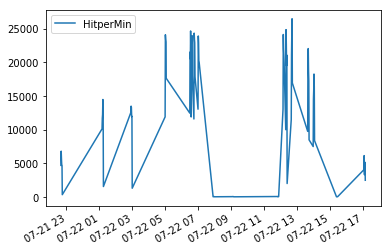

In [39]:
import matplotlib.pyplot as plt 
plt.figure()
loadperMinPandasDf.plot()
plt.show()

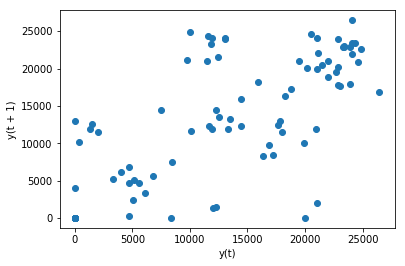

In [40]:
from pandas.plotting import lag_plot

lag_plot(loadperMinPandasDf)

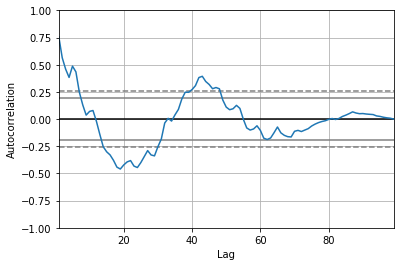

In [41]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(loadperMinPandasDf)

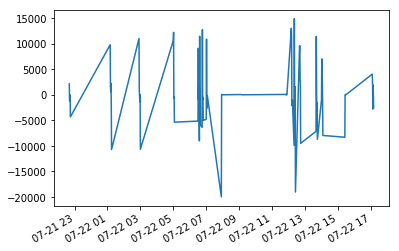

In [54]:
loadperMinPandasDf['diff'] = loadperMinPandasDf['HitperMin'] - loadperMinPandasDf['HitperMin'].shift(1)
loadperMinPandasDf['diff'].dropna().plot()

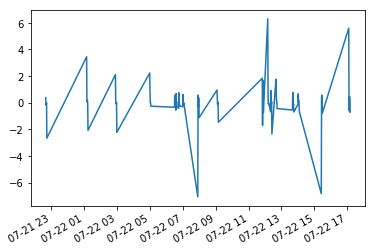

In [55]:
import numpy as np
loadperMinPandasDf['#HitperMin_log'] = np.log(loadperMinPandasDf['HitperMin'])
loadperMinPandasDf['#HitperMin_log_diff'] = loadperMinPandasDf['#HitperMin_log'].diff()
loadperMinPandasDf['#HitperMin_log_diff'].dropna().plot()